In [1]:
import pandas as pd
import numpy as np
import warnings 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.decomposition import PCA

In [2]:
warnings.filterwarnings('ignore')

In [3]:
food = pd.read_csv('openfoodfacts.csv', engine = 'python', sep = '\t', on_bad_lines = 'skip')

In [4]:
food.shape

(320767, 162)

1. Nettoyage des variables avec trop peu de valeurs
- il y a beaucoup de variables avec très peu de valeurs, on va retenir les variables avec plus 10% individus avec valeurs .

In [5]:
food.notna().sum()/len(food)

code                       0.999928
url                        0.999928
creator                    0.999994
created_t                  0.999991
created_datetime           0.999972
                             ...   
carbon-footprint_100g      0.000835
nutrition-score-fr_100g    0.689616
nutrition-score-uk_100g    0.689616
glycemic-index_100g        0.000000
water-hardness_100g        0.000000
Length: 162, dtype: float64

In [6]:
food_1 = food
for var in food:
    if food[var].isna().sum()/len(food) > 0.9:
        food_1 = food_1.drop([var], axis = 1)

In [7]:
food_1.shape

(320767, 62)

100 variables sur 162 variables sont écartées ainsi. 

2. Nettoyage des variables inutiles pour l'application : Notre application utilisent les variables quantitive suivantes pour chaque type de population, les autres variabales quantitatives sont eliminées : Energie (kcal)	vitamine_A (microGrammes)	vitamine C (mg)	calcium (mg), fer (mg)	protein (g)	glucide/carbonhydrate (g)	lipide/gras (g)	sel max (g)	sucre max (g)

    - eliminer les variables temps: 
    - éliminer les variables doublons qui termine par '_tags', 'url',  '_fr' (sauf grade_fr)
    - éliminer les variables non signficatives pour l'application

In [8]:
food_2 = food_1.drop(['created_t', 'last_modified_t', 'last_modified_datetime', 'created_datetime'], axis = 1)

In [9]:
for var in food_2:
    if (var[-3:] == 'url' or var[-5:] == '_tags') :
        food_2 = food_2.drop([var], axis =1)

In [10]:
for var in food_2:
    if (var[-3:] == '_fr' and var[-8:] != 'grade_fr') :
        food_2 = food_2.drop([var], axis =1)

In [11]:
food_2 = food_2.drop(['creator','categories', 'quantity', 'generic_name','packaging','manufacturing_places',
                           'labels','ingredients_text','purchase_places','main_category',
                           'stores','ingredients_from_palm_oil_n','ingredients_that_may_be_from_palm_oil_n',
                           'additives_n','additives','states', 'pnns_groups_1','pnns_groups_2',
                           'nutrition-score-uk_100g', 'saturated-fat_100g', 'trans-fat_100g', 'cholesterol_100g', 'sodium_100g', 'fiber_100g', 'brands', 'countries', 'serving_size'], axis =1)

In [12]:
food_2.to_csv('food_2.csv')

In [13]:
food_2.shape

(320767, 14)

3. Nettoyage des individus qui ne peuvent pas être utilisés par l'application:  
        - éliminier les produits avec code ou product_name vide  
        - éliminer les produits dont plus 80% valeurs (8 sur 10) nutriments sont manquantes

In [17]:
(food_2['code'].isna().sum() | food_2['product_name'].isna().sum())/len(food_2)

0.05543899465967509

In [18]:
food_3= food_2.loc[food_2['product_name'].notna() & food_2['code'].notna()]

5.5% produits nettoyés

In [19]:
nutri_col = ['energy_100g', 'fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g','salt_100g','vitamin-a_100g','vitamin-c_100g','calcium_100g','iron_100g']
food_nutri = food_3[nutri_col]
((food_nutri.apply(lambda x: x.isnull().sum(), axis=1) > 8).sum())/len(food_2)

0.1392630788079821

14% produits nettoyés en raison de plus 80% valeurs manquantes.

In [22]:
food_3 = food_3.loc[food_nutri.apply(lambda x: x.isnull().sum(), axis=1) <= 8]
food_3.shape

(258311, 14)

In [133]:
food_3.to_csv('food_3.csv')

4. Remplacer les valeurs invalides  (< 0, ou > 100) des nutriments par la moyenne, pour energy invalide est > 10000

In [183]:
food_4 = food_3.copy()

In [184]:
food_4['fat_100g'].apply(lambda x: (x > 100 or x < 0)).sum()

4

In [185]:
food_4['carbohydrates_100g'].apply(lambda x: (x > 100 or x < 0)).sum()

18

In [186]:
food_4['sugars_100g'].apply(lambda x: (x > 100 or x < 0)).sum()

18

In [187]:
food_4['calcium_100g'].apply(lambda x: (x > 5 or x < 0)).sum()

45

In [188]:
food_4['vitamin-c_100g'].apply(lambda x: (x > 5 or x < 0)).sum()

42

In [189]:
food_4['iron_100g'].apply(lambda x: (x > 5 or x < 0)).sum()

13

In [190]:
food_4['salt_100g'].apply(lambda x: (x > 100 or x < 0)).sum()

154

In [191]:
food_4['proteins_100g'].apply(lambda x: (x > 100 or x < 0)).sum()

4

In [192]:
food_4['vitamin-a_100g'].apply(lambda x: (x > 5 or x < 0)).sum()

2

In [193]:
food_4['energy_100g'].apply(lambda x: (x > 10000 or x < 0)).sum()

16

Total 326 valeurs invalides à corriger

In [195]:
food_4['fat_100g'] = food_4['fat_100g'].apply(lambda x: food_4['fat_100g'].mean() if (x > 100 or x < 0) else x)
food_4['carbohydrates_100g'] = food_4['carbohydrates_100g'].apply(lambda x: food_4['carbohydrates_100g'].mean() if (x > 100 or x < 0) else x)
food_4['sugars_100g'] = food_4['sugars_100g'].apply(lambda x: food_4['sugars_100g'].mean() if (x > 100 or x < 0) else x)
food_4['vitamin-a_100g'] = food_4['vitamin-a_100g'].apply(lambda x: food_4['vitamin-a_100g'].mean() if (x > 5 or x < 0) else x)
food_4['vitamin-c_100g'] = food_4['vitamin-c_100g'].apply(lambda x: food_4['vitamin-c_100g'].mean() if (x > 5 or x < 0) else x)
food_4['calcium_100g'] = food_4['calcium_100g'].apply(lambda x: food_4['calcium_100g'].mean() if (x > 5 or x < 0) else x)
food_4['iron_100g'] = food_4['iron_100g'].apply(lambda x: food_4['iron_100g'].mean() if (x > 5 or x < 0) else x)
food_4['salt_100g'] = food_4['salt_100g'].apply(lambda x: food_4['salt_100g'].mean() if (x > 100 or x < 0) else x)
food_4['proteins_100g'] = food_4['proteins_100g'].apply(lambda x: food_4['proteins_100g'].mean() if (x > 100 or x < 0) else x)
food_4['energy_100g'] = food_4['energy_100g'].apply(lambda x: food_4['energy_100g'].mean() if (x > 10000 or x < 0) else x)


In [196]:
food_4.to_csv('food_4.csv')

5. traitement des valeurs manquantes soit par la moyenne, par la médiane et par la relation 

In [197]:
food_5 = pd.read_csv('food_4.csv', index_col=[0])

In [198]:
food_5.isnull().sum().sum()

615290

In [229]:
total = food_5.isnull().sum().sort_values(ascending=False)
percent = (food_5.isnull().sum()/food_5.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

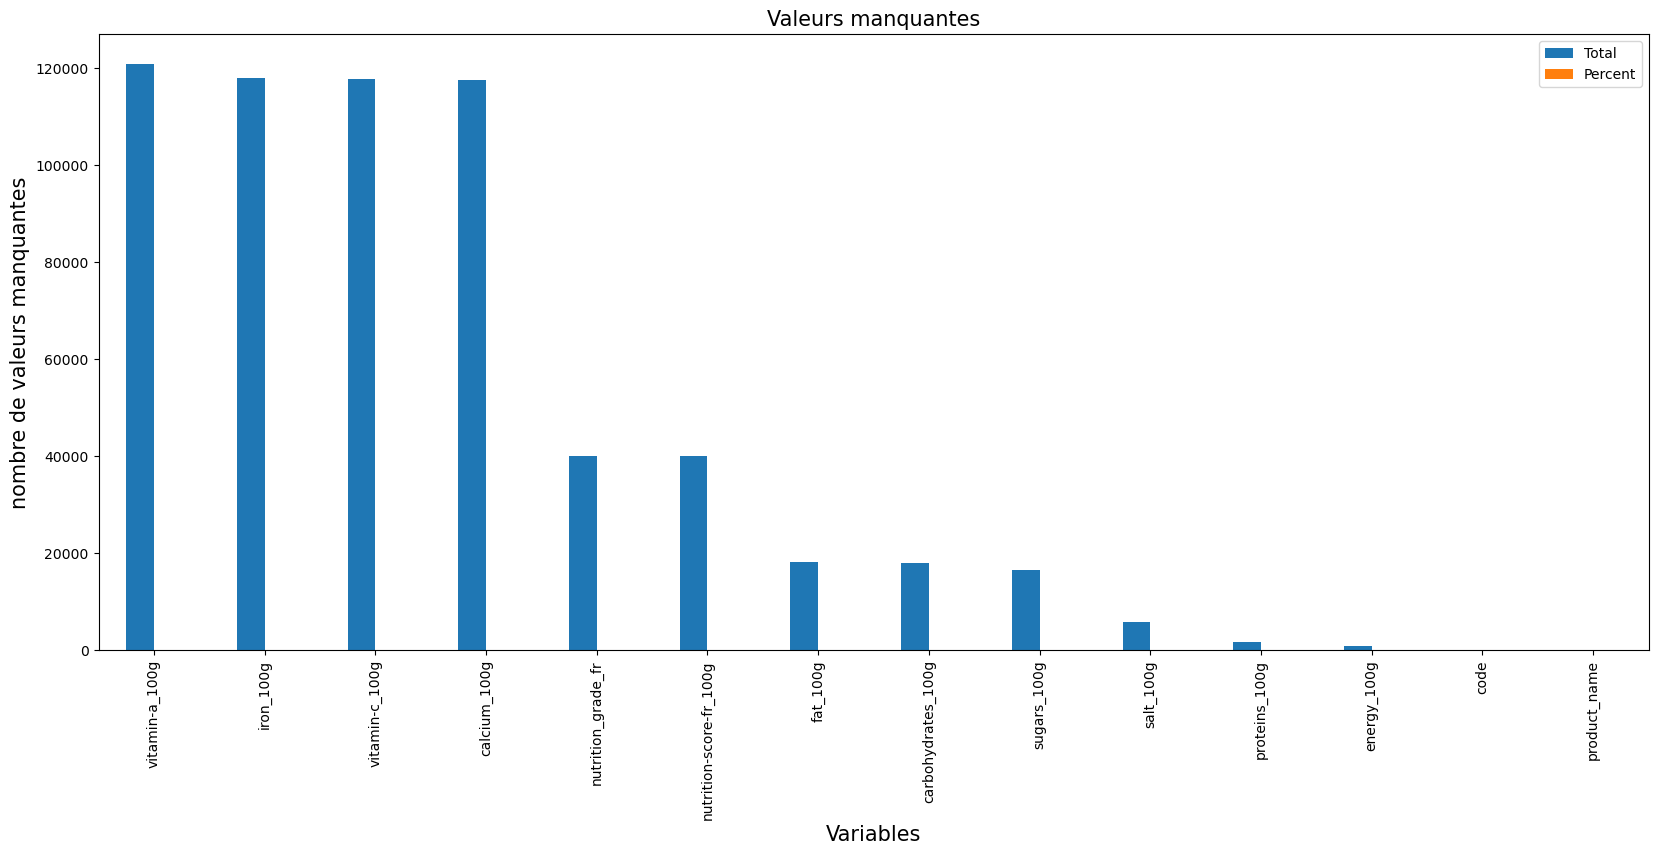

In [200]:
missing_data.plot(kind='bar', figsize=(20, 8))
plt.xlabel('Variables', fontsize=15)
plt.ylabel('nombre de valeurs manquantes', fontsize=15)
plt.title('Valeurs manquantes', fontsize=15)
plt.show()

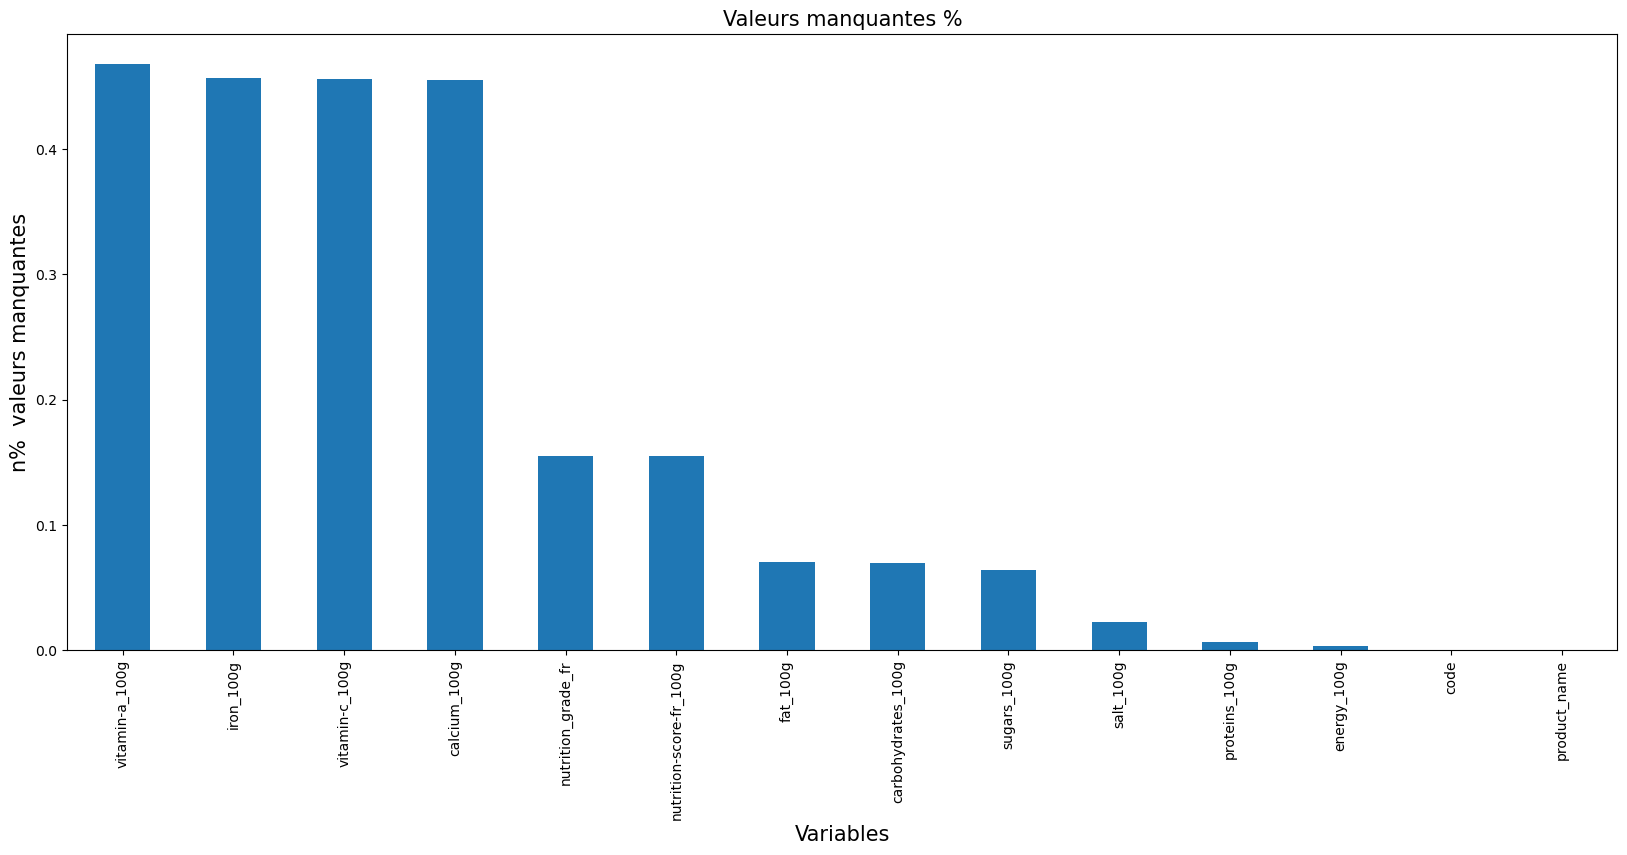

In [228]:
percent.plot(kind='bar', figsize=(20, 8))
plt.xlabel('Variables', fontsize=15)
plt.ylabel('n%  valeurs manquantes', fontsize=15)
plt.title('Valeurs manquantes %', fontsize=15)
plt.show()

In [201]:
food_5['energy_100g'].fillna(food_5['energy_100g'].mean(), inplace=True)
food_5['fat_100g'].fillna(food_5['fat_100g'].mean(), inplace=True)
food_5['carbohydrates_100g'].fillna(food_5['carbohydrates_100g'].mean(), inplace=True)
food_5['sugars_100g'].fillna(food_5['sugars_100g'].mean(), inplace=True)
food_5['vitamin-a_100g'].fillna(food_5['vitamin-a_100g'].mean(), inplace=True)
food_5['vitamin-c_100g'].fillna(food_5['vitamin-c_100g'].mean(), inplace=True)
food_5['calcium_100g'].fillna(food_5['calcium_100g'].mean(), inplace=True)
food_5['iron_100g'].fillna(food_5['iron_100g'].mean(), inplace=True)
food_5['salt_100g'].fillna(food_5['salt_100g'].mean(), inplace=True)
food_5['proteins_100g'].fillna(food_5['proteins_100g'].mean(), inplace=True)

In [202]:
food_5['nutrition-score-fr_100g'].fillna(food_5['nutrition-score-fr_100g'].median(), inplace=True)

remplace la valeur manquante de nutrition_grade_fr via la relation entre nutrition_grade_fr et nutrition-score-fr_100g : 
    a < 0, 0<=b < 3, 3<=c <=10, 10 < d < 20, e >= 20. 

In [203]:
def condition(x):
    if x < 0:
        return "a"
    elif x>=0 and x<3:
        return "b"
    elif x>=3 and x<=10:
        return "c"
    elif x>10 and x<20:
        return "d"
    else:
        return "e"
food_5['nutrition_grade_fr'] = food_5['nutrition-score-fr_100g'].apply(condition)

In [204]:
food_5 = food_5.drop(['nutrition-score-fr_100g'], axis = 1)

In [205]:
food_5.isnull().sum().sum()

0

Explication:;   Il n'y a plus de valeurs manquantes

In [206]:
food_5.to_csv('food_5.csv')

6:  traitement des outliers

In [233]:
food_6 = food_5.copy()

Calcul de pourcentage d'outliers par variables et le nombre total d'outliers

In [234]:
Q1 = food_6.quantile(0.25)
Q3 = food_6.quantile(0.75)
IQR = Q3 - Q1
outliers = (food_6 < (Q1 - 1.5 * IQR)) | (food_6 > (Q3 + 1.5 * IQR))
outliers_num = (outliers == True).sum().sort_values(ascending=False)
outliers_per = ((outliers == True).sum()/len(food_6)).sort_values(ascending=False)
(outliers == True).sum().sum()

109724

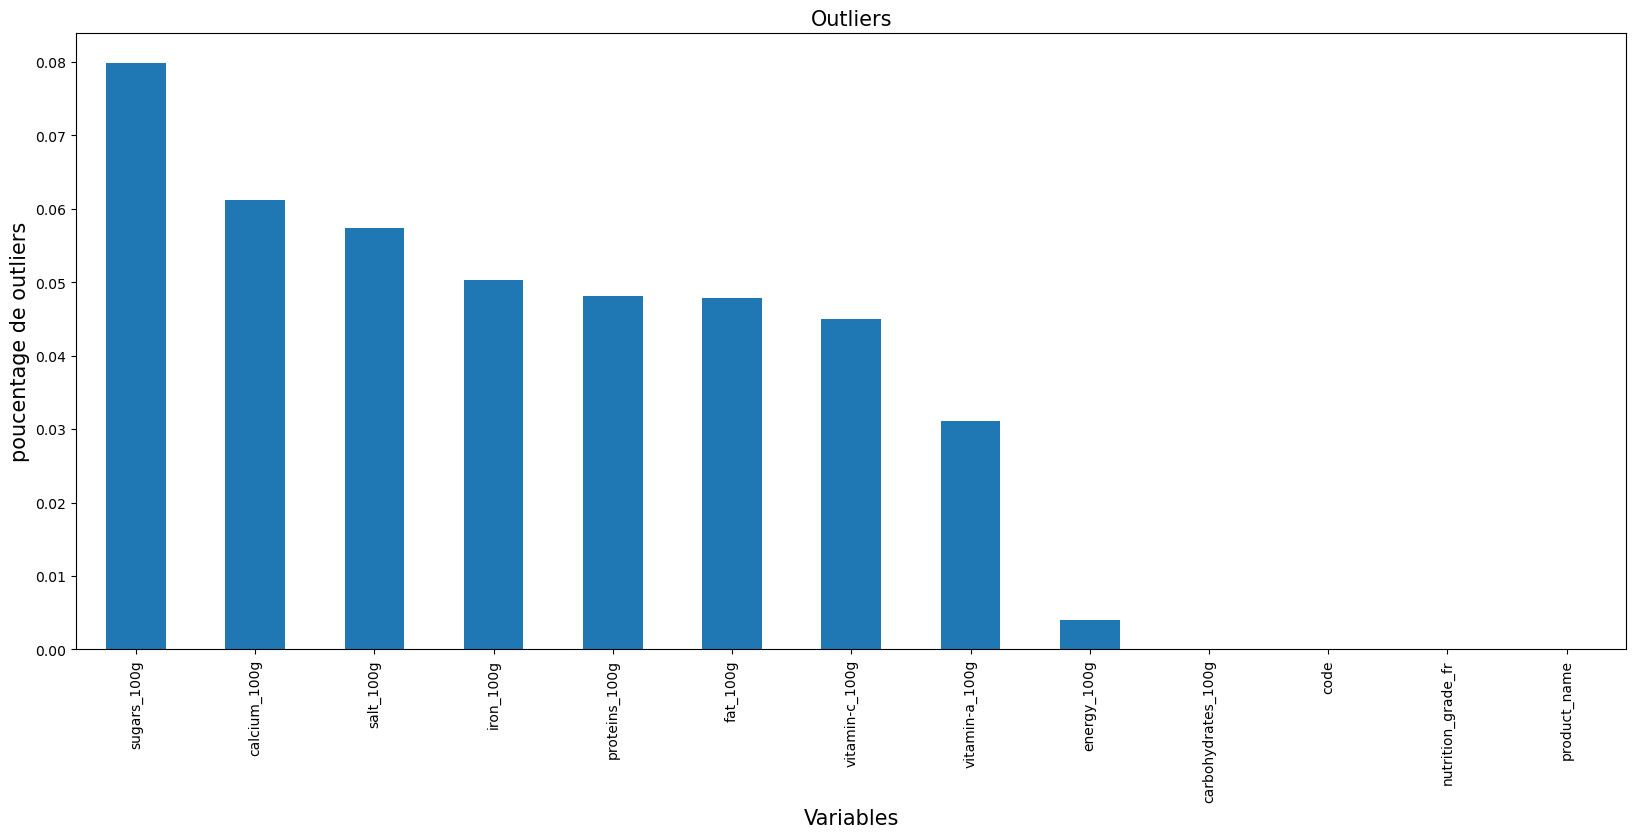

In [235]:
outliers_per.plot(kind='bar', figsize=(20, 8))
plt.xlabel('Variables', fontsize=15)
plt.ylabel('poucentage de outliers', fontsize=15)
plt.title('Outliers', fontsize=15)
plt.show()

Information:  calcium, sugars et salt ont de pourcentage d'outlier > 5%.  pas d'outliers pour carbohydrate, seulement 0.5% pour l'energy.  

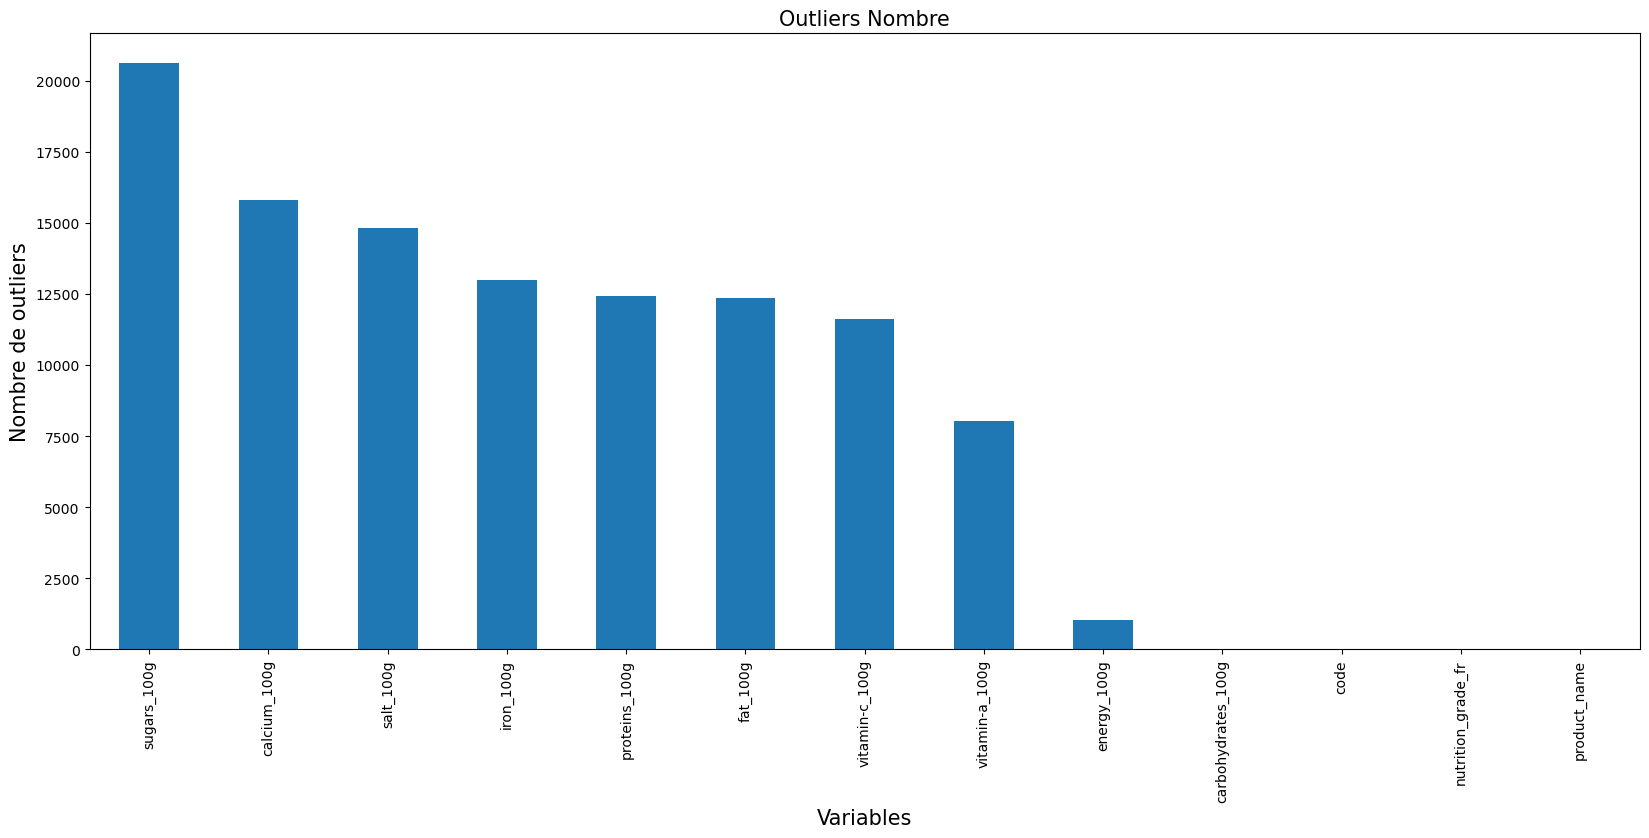

In [236]:
outliers_num.plot(kind='bar', figsize=(20, 8))
plt.xlabel('Variables', fontsize=15)
plt.ylabel('Nombre de outliers', fontsize=15)
plt.title('Outliers Nombre', fontsize=15)
plt.show()

Nous visualison les outliers sur le boxplot. 

In [237]:
food_6_a = food_6['energy_100g']
food_6_b = food_6[['fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g','salt_100g']]
food_6_c = food_6[['vitamin-a_100g','vitamin-c_100g','calcium_100g','iron_100g']]

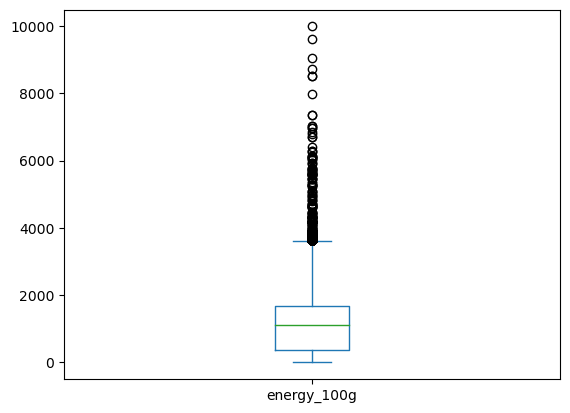

In [238]:
# Visualise outliers
food_6_a.plot.box()
plt.show()

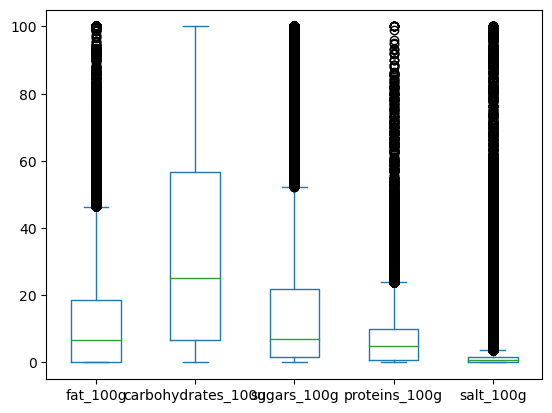

In [239]:
# Visualise outliers
food_6_b.plot.box()
plt.show()

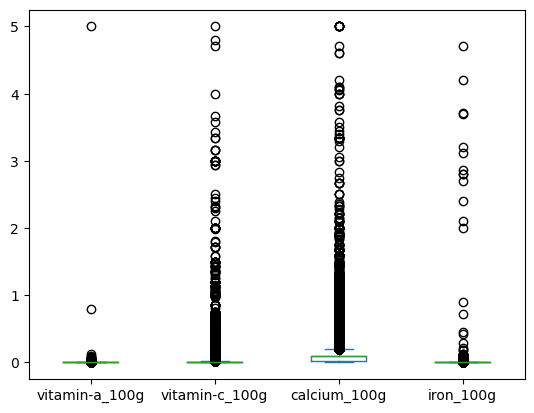

In [240]:
# Visualise outliers
food_6_c.plot.box()
plt.show()

In [241]:
# Remove outliers
food_6 = food_6[~outliers.any(axis=1)]

In [244]:
food_6.duplicated().sum()

3

In [245]:
# remove duplicated
food_7 = food_6.drop_duplicates(keep=False)

In [246]:
food_7.shape

(175280, 13)

In [247]:
food_7.notna().sum()/len(food_7)

code                  1.0
product_name          1.0
nutrition_grade_fr    1.0
energy_100g           1.0
fat_100g              1.0
carbohydrates_100g    1.0
sugars_100g           1.0
proteins_100g         1.0
salt_100g             1.0
vitamin-a_100g        1.0
vitamin-c_100g        1.0
calcium_100g          1.0
iron_100g             1.0
dtype: float64

In [248]:
food_7.to_csv('food_7.csv')